In [82]:
import pickle
import openslide
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.metrics import roc_auc_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.cm as cm

### Load in `.sav` , `.svs` and `.xml`

In [83]:
# Load in the file saving all the processing information
with open('/home/zhenzhen/MIL-seg/results/anders/anders_segmentation.sav','rb') as handle:
    dat = pickle.load(handle)
handle.close()
meta = pd.read_csv('/home/zhenzhen/MIL-seg/meta_anders.csv')

slide_id = '458601'
slide = openslide.OpenSlide('/mnt/data0/zhenzhen/anders/'+slide_id+'.svs')
slide_info = dat[slide_id]
slide_annot = ET.parse('/mnt/data0/zhenzhen/anders/'+slide_id+'.xml').getroot()

### Basic Information
* Thumbnail
* Size

In [84]:
def read_annotation(root):
    points_arr_tumor = []
    points_arr_stroma = []
    for r in root.iter('Annotation'):
        if r.attrib['Id']== '1':
            for v in r.iter('Vertex'):
                points_arr_tumor.append((int(v.attrib['X']), int(v.attrib['Y'])))
        if r.attrib['Id']== '2':
            for v in r.iter('Vertex'):
                points_arr_stroma.append((int(v.attrib['X']), int(v.attrib['Y'])))
    return points_arr_tumor, points_arr_stroma

(47807, 45215) / {'width': 47807, 'height': 45215}
92 {'tumor': 185770, 'stroma': 10829} {'tolerant_mean_band': 3, 'mean_reference': 243, 'fill_ratio_threshold': 0.3} {'tumor': 124645, 'stroma': 6854}


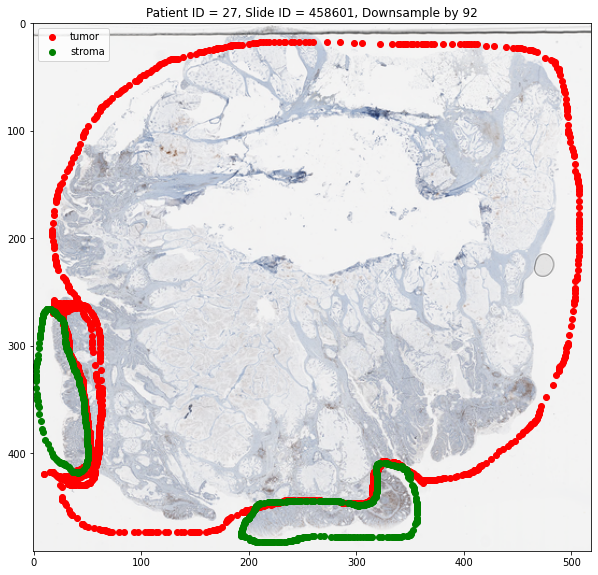

In [85]:
# Thumbnail
f,ax = plt.subplots(figsize=(10,10))
width,height = slide.dimensions
thumbnail_factor = 92
points_arr_tumor, points_arr_stroma = read_annotation(slide_annot)
tumor_x = [i[0]//thumbnail_factor for i in points_arr_tumor ]
tumor_y = [i[1]//thumbnail_factor for i in points_arr_tumor ]
stroma_x = [i[0]//thumbnail_factor for i in points_arr_stroma ]
stroma_y = [i[1]//thumbnail_factor for i in points_arr_stroma ]
ax.imshow(slide.get_thumbnail((width//thumbnail_factor,height//thumbnail_factor)))
ax.scatter(tumor_x,tumor_y, c='r',label = 'tumor')
ax.scatter(stroma_x,stroma_y, c='g',label = 'stroma')
ax.legend()
ax.set_title("Patient ID = {}, Slide ID = {}, Downsample by {}".format(slide_info['patient_id'],slide_id,thumbnail_factor))

print(slide.dimensions,'/',slide_info['slide_size']) # Size
print(slide_info['patch_shape'],slide_info['all_patches'],slide_info['Train']['non_blank_request'],slide_info['Train']['non_blank_patches']) # Tiles

### Training Process
* Accuracy curve
* Loss curve
* ROC curve

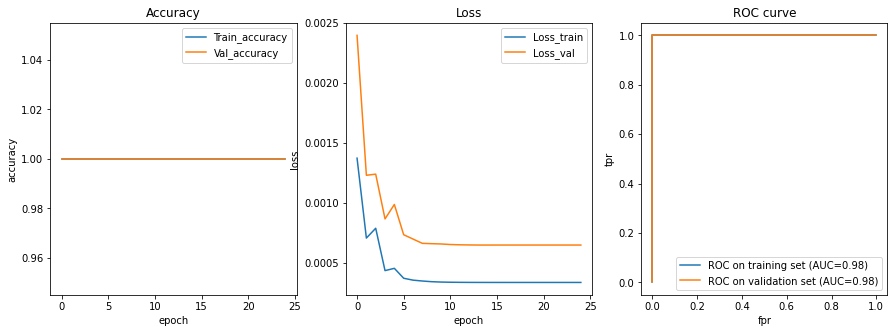

In [86]:
f,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot([float(i) for i in slide_info['Train']['metrics']['Train_accuracy']],label='Train_accuracy')
ax[0].plot([float(i) for i in slide_info['Train']['metrics']['Val_accuracy']],label='Val_accuracy')
ax[1].plot([float(i) for i in slide_info['Train']['metrics']['Loss_train'][1:-1].split(',')],label='Loss_train')
ax[1].plot([float(i) for i in slide_info['Train']['metrics']['Loss_val'][1:-1].split(',')],label='Loss_val')
fpr = [float(i) for i in slide_info['Train']['metrics']['fpr_train']]
tpr = [float(i) for i in slide_info['Train']['metrics']['tpr_train']]
roc_auc_train =  roc_auc_score(fpr,tpr)
ax[2].plot(fpr,tpr, label = "ROC on training set (AUC=%.2f)" % roc_auc_train)
fpr = [float(i) for i in slide_info['Train']['metrics']['fpr_val']]
tpr = [float(i) for i in slide_info['Train']['metrics']['tpr_val']]
roc_auc_val =  roc_auc_score(fpr,tpr)
ax[2].plot(fpr,tpr, label = "ROC on validation set (AUC=%.2f)" % roc_auc_val)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set(title="Accuracy",xlabel="epoch",ylabel='accuracy')
ax[1].set(title="Loss",xlabel="epoch",ylabel='loss')
ax[2].set(title="ROC curve",xlabel="fpr",ylabel='tpr')
f.show()

### Heatmap

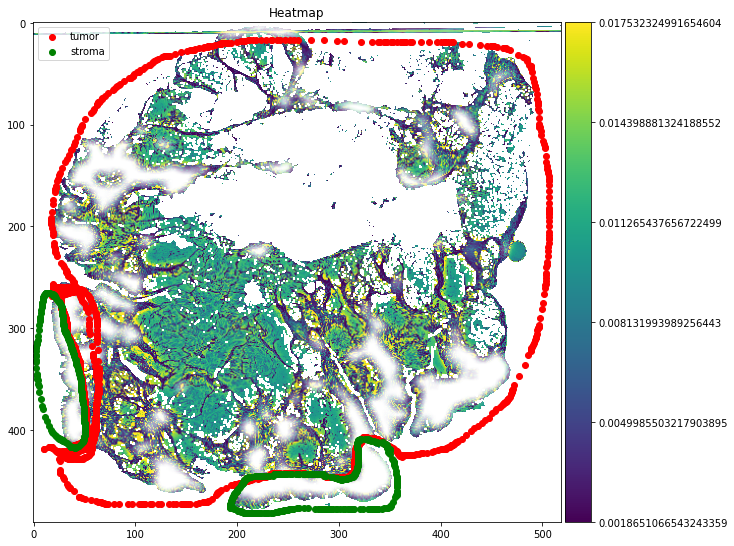

In [87]:
hot_map_instance = np.load(os.path.join('/home/zhenzhen/MIL-seg/results/anders/'+slide_id+'/neighbor/hot_map_instance.npy'))
hot_map_bag = np.load(os.path.join('/home/zhenzhen/MIL-seg/results/anders/'+slide_id+'/neighbor/hot_map_bag.npy'))

vmin = np.nanpercentile(hot_map_instance[hot_map_bag>0.5],5)
vmax = np.nanpercentile(hot_map_instance[hot_map_bag>0.5],95)
hot_map_instance_01 = (hot_map_instance-vmin)/(vmax-vmin)
cmap = cm.get_cmap()
RGBA = cmap(hot_map_instance_01)
RGBA[...,-1]= hot_map_bag

f,ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right',size='5%',pad=0.05)
im = ax.imshow(RGBA)
cb = f.colorbar(im, cax = cax, orientation='vertical')
ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels(ticks*(vmax-vmin) + vmin)

ax.scatter(tumor_x,tumor_y, c='r',label = 'tumor')
ax.scatter(stroma_x,stroma_y, c='g',label = 'stroma')
ax.legend()

ax.set_title("Heatmap")
f.show()